In [1]:
import os
import re
import pickle
from tqdm import tqdm
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from keras.layers import Embedding
from  keras . utils  import  to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D,Conv2D, MaxPooling1D, Embedding, Flatten
from keras.models import Model
from keras.initializers import Constant
from keras.layers import Embedding

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import pandas as pd 
df_train=pd.read_csv('gdrive/My Drive/Thesis Data/full doc csv/full_doc_train.csv')
df_test=pd.read_csv('gdrive/My Drive/Thesis Data/full doc csv/full_doc_test.csv')
total_data = pd.concat([df_train,df_test])
print(len(total_data))
total_data = total_data[(total_data['label']=='politics') | (total_data['label']=='sports') | (total_data['label']=='education')] # previously we erase these 3 labels of text,now we take these 3 labels of text
print(len(total_data))
# df.to_csv(news/'news_3less.csv',index=False) # convert the data to csv format

95855
44165


In [4]:
!git clone -l -s https://github.com/banglakit/bengali-stemmer.git

Cloning into 'bengali-stemmer'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 94 (delta 5), reused 16 (delta 4), pack-reused 69
Unpacking objects: 100% (94/94), done.


In [5]:
!pip install git+https://github.com/banglakit/bengali-stemmer.git    

  Cloning https://github.com/banglakit/bengali-stemmer.git to /tmp/pip-req-build-_rlon_c0
  Running command git clone -q https://github.com/banglakit/bengali-stemmer.git /tmp/pip-req-build-_rlon_c0
  Created wheel for bengali-stemmer: filename=bengali_stemmer-0.0.1-py2.py3-none-any.whl size=6393 sha256=d5be28e16a6206956bf1f4230b43a0f86d2e4e2a5850e00b820db4705f92af8d
  Stored in directory: /tmp/pip-ephem-wheel-cache-dsohg8hq/wheels/a1/ad/a1/4ba354059b17c00600a14e13a504e7bdb49f20f2f4e2f3639c
Successfully built bengali-stemmer


In [6]:
from bengali_stemmer.rafikamal2014 import RafiStemmer
stemmer = RafiStemmer()
stemmer.stem_word('বাংলায়')

'বাংলা'

In [7]:
macronum=sorted(set(total_data['label']))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))

def fun(i):
    return macro_to_id[i]

total_data['label']=total_data['label'].apply(fun)


In [8]:
texts = list(total_data['text'])
labels = list(total_data['label'])


In [9]:
def clean_punct(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#|।|’|‘]', r'', sentence)
    cleaned1 = re.sub(r'[.|,|(|)|\|/]', r'', cleaned)
    cleaned = re.sub(r'[০|১|২|৩|৪|৫|৬|৭|৮|৯]', r'', cleaned1)
    cleaned1 = re.sub(r'[-|=]', r' ', cleaned)
    return cleaned1

In [11]:
stopwords=pd.read_csv('gdrive/My Drive/Colab Notebooks/Stopwords.csv')

set_stop = set(stopwords['words'])

In [12]:

def pre_process(data):
    i=0
    str1=' '
    final_string = []
    final_words = []
    all_negative_words = []
    s=''

    for sentence in data:
        filtered_sentence = []

        for w in sentence.split():
            for cleaned_word in clean_punct(w).split():
                if len(cleaned_word)>2:
                    if((cleaned_word) not in set_stop):
                        s = stemmer.stem_word(cleaned_word)
                        if len(s)>2:
                            final_words.append(s)
                            filtered_sentence.append(s)
                    else:
                        continue
                else:
                    continue

        str1 = " ".join(filtered_sentence)
        final_string.append(str1)
    return final_string

In [13]:
texts = pre_process(texts)

In [14]:
texts[0]

'আদাল অতি উৎসাহী রিট আবেদন কারণ নারায়ণগঞ্জ সাত খুন মামল কার্যক্রম বাধাগ্রস্ত মন্তব্য প্রধানমন্ত্রী শেখ হাসিনা অতি উৎসাহী কর্মকাণ্ড কারণ অপরাধী সজাগ আইনশৃঙ্খলা রক্ষাকারী বাহিনীর ব্যাঘাত প্রধানমন্ত্রী যখন ব্যবস্থা তখন মানুষ অতি উৎসাহী কর্মকাণ্ড কার্যক্রম ব্যাহত কথা কথা রিট অর্ড কাজ নির্বাহী বিভাগ আইন শৃঙ্খলা বাহিনীর কথা; কাজ বিচ বিভাগ করণী হাত বেঁধ হয়েছে—এ পরিস্থিতির সৃষ্ গতকাল বুধব গণভবন আওয়ামী লীগ কার্যনির্বাহী সংস সূচনা বক্তব্য শেখ হাসিনা এসব কথা আইন বিচ নির্বাহী বিভাগ অপর পরিপূরক অতি উৎসাহী অসুবিধা হয়৷ অপর বাধা সৃষ্ সবাই বুঝ উৎসাহ নিজ প্রধানমন্ত্রী অনিয়ম ব্যবস্থা নিয়ে ভবিষ্য নেব আত্মী দেখ অন্যা বিচ নারায়ণগঞ্জ সাত খুন তদন্ত বিচ আশ্বাস প্রধানমন্ত্রী কখনো অন্যা প্রশ্র দেইনি ভবিষ্য দেব সাত খুন জড়িত কোথা থাক খঁুজ শাস্তি দেব৷ কখন কোন পন্থা হবে—আম ভালোভাব সাত খুন মামল প্রধান আসামি সিদ্ধিরগঞ্জ আওয়ামী লীগ সহসভাপতি নূর হোস প্রসঙ্গ শেখ হাসিনা সাত খুন শিক সবা আওয়ামী লীগ লোক আসামি বিএনপির সৃষ্টি৷ জাতী পার্ ছিলেন৷ লোক সরক পার্ ক্ষতিকারক৷ শিক্ষাপ্রতিষ্ঠান অনেক খাঁ কর্মী হাত কাট র্যাব বিলুপ্

In [15]:
def load_data(num_words, sequence_length, test_size=0.25, oov_token=None):
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
    num_classes=3
    y = to_categorical(np.asarray(labels), num_classes)
    tokenizer.fit_on_texts(texts)
    X = tokenizer.texts_to_sequences(texts)
    X = np.array(X)
    # pad sequences with 0's
    X = pad_sequences(X, maxlen=sequence_length)
    # split data to training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)
    data = {}
    data["X_train"] = X_train
    data["X_test"]= X_test
    data["y_train"] = y_train
    data["y_test"] = y_test
    data["tokenizer"] = tokenizer
    return data

In [16]:
# train_data=pd.read_csv('gdrive/My Drive/Colab Notebooks/ulm_train.csv')
import numpy as np

def get_embedding_vectors(word_index, embedding_size=100):
    
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_size))
    with open(f"gdrive/My Drive/Colab Notebooks/bn_glove.{embedding_size}d.txt", encoding="utf8") as f:
        for line in tqdm(f, "Reading GloVe"):
            values = line.split()
            # get the word as the first word in the line
            word = values[0]
            if word in word_index:
                idx = word_index[word]
                # get the vectors as the remaining values in the line
                embedding_matrix[idx] = np.array(values[1:], dtype="float32")
    return embedding_matrix

In [17]:
d = set()
for s in texts:
    for ss in list(s.split()):
        d.add(ss)

In [18]:
len(d)

185341

In [19]:
max([len(s.split()) for s in texts]) # find the max length

5154

In [20]:
MAX_SEQUENCE_LENGTH = 5154    #max([len(s.split()) for s in texts]) 
MAX_NUM_WORDS = 177340 + 1
vocab_size = MAX_NUM_WORDS
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.2

data = load_data(MAX_NUM_WORDS , MAX_SEQUENCE_LENGTH,VALIDATION_SPLIT)

In [21]:
len(data['tokenizer'].word_index)

177340

In [22]:
embedding_matrix = get_embedding_vectors( data['tokenizer'].word_index ,EMBEDDING_DIM )

Reading GloVe: 134256it [00:07, 17761.15it/s]


In [23]:
embedding_layer = Embedding(len(data['tokenizer'].word_index) + 1,  # or we can use 'MAX_NUM_WORDS'
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
#model.add(Embedding(vocabulary_size, EMBEDDING_DIM, input_length=row_max_length)), find that from kaggle


In [24]:
# create the model
embedding_vecor_length = 300
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(100))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 5154, 300)         53202300  
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 3)                 303       
Total params: 53,363,003
Trainable params: 160,703
Non-trainable params: 53,202,300
_________________________________________________________________
None


In [25]:
history = model.fit(data['X_train'], data['y_train'], validation_data=(data['X_test'], data['y_test']),batch_size=64, epochs=10, verbose=2)

Epoch 1/10
553/553 - 201s - loss: 0.4240 - accuracy: 0.8534 - val_loss: 0.3618 - val_accuracy: 0.8828
Epoch 2/10
553/553 - 203s - loss: 0.2711 - accuracy: 0.9125 - val_loss: 0.2271 - val_accuracy: 0.9254
Epoch 3/10
553/553 - 204s - loss: 0.2155 - accuracy: 0.9242 - val_loss: 0.4925 - val_accuracy: 0.8112
Epoch 4/10
553/553 - 206s - loss: 0.3045 - accuracy: 0.8992 - val_loss: 0.2163 - val_accuracy: 0.9223
Epoch 5/10
553/553 - 206s - loss: 0.1761 - accuracy: 0.9363 - val_loss: 0.1978 - val_accuracy: 0.9307
Epoch 6/10
553/553 - 205s - loss: 0.1499 - accuracy: 0.9440 - val_loss: 0.1534 - val_accuracy: 0.9418
Epoch 7/10
553/553 - 205s - loss: 0.1250 - accuracy: 0.9503 - val_loss: 0.1316 - val_accuracy: 0.9445
Epoch 8/10
553/553 - 205s - loss: 0.1067 - accuracy: 0.9521 - val_loss: 0.1183 - val_accuracy: 0.9472
Epoch 9/10
553/553 - 205s - loss: 0.0976 - accuracy: 0.9547 - val_loss: 0.1188 - val_accuracy: 0.9467
Epoch 10/10
553/553 - 204s - loss: 0.0923 - accuracy: 0.9568 - val_loss: 0.1191 - 

In [26]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
def confussion_mat(model):
    # Predict the values from the validation dataset
    Y_pred = model.predict(data['X_test'])
    # Convert predictions classes to one hot vectors 
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    # Convert validation observations to one hot vectors
    Y_true = np.argmax(data['y_test'],axis = 1) 
    # compute the confusion matrix
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    # plot the confusion matrix
    f,ax = plt.subplots(figsize=(15, 15))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

In [27]:
def history2(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


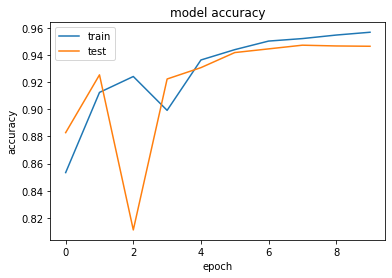

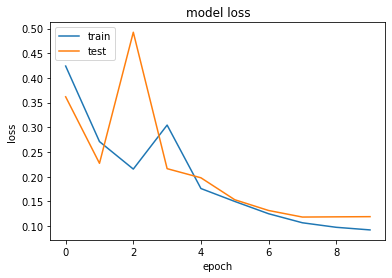

In [28]:
history2(history)

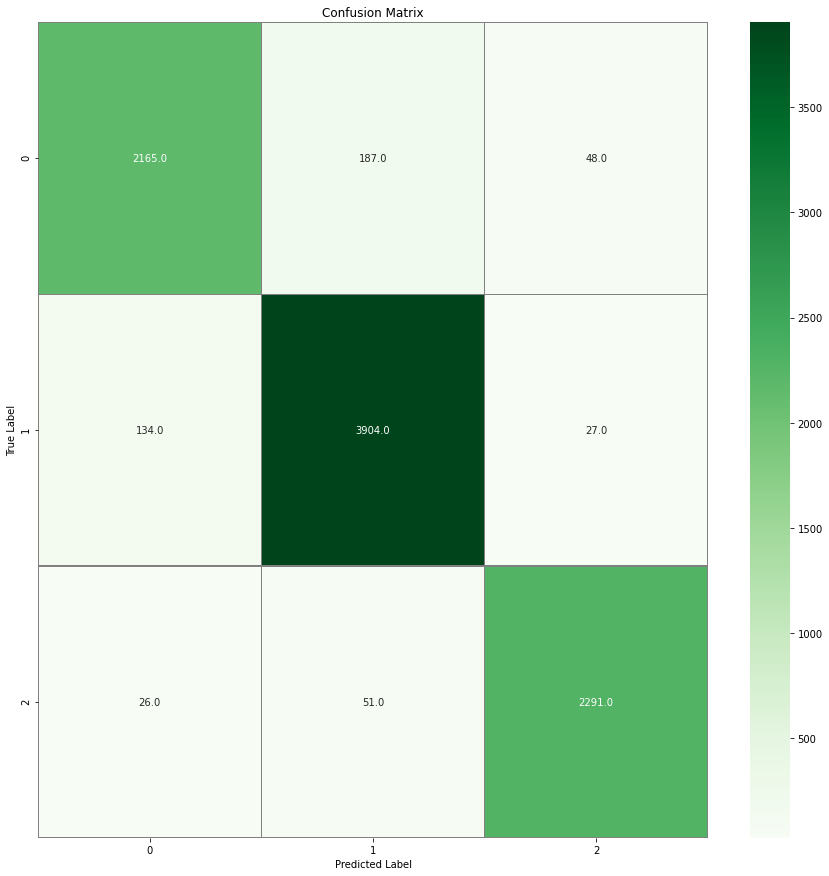

In [29]:
confussion_mat(model)